# Dirichlet distribution tutorial

#### What are Dirichlet distributions?

The **Dirichlet distribution** is a multivariate probability distribution defined over the probability simplex.
It is commonly used to model **uncertainty over categorical probability vectors**, i.e. vectors that are
non-negative and sum to one.

In the 3-dimensional case, the simplex can be visualized as an **equilateral triangle**, making ternary plots
a natural and intuitive way to understand Dirichlet behavior.


## 1. Imports:

First of all we import the necessary packages.

In [5]:
import numpy as np

from probly.visualization.dirichlet.dirichlet_visualization import create_dirichlet_plot

print("Imports successfully loaded.")

Imports successfully loaded.


## 2. Test Dirichlet distribution plot:
Let's generate a Dirichlet plot with the `alpha values (8, 2, 2)`. Where the values corespond to the likelyhood of an outcome.


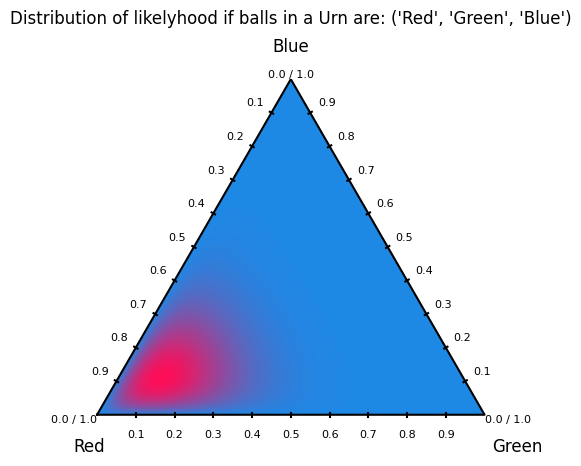

<Axes: title={'center': "Distribution of likelyhood if balls in a Urn are: ('Red', 'Green', 'Blue')"}>

In [6]:
alpha_values = np.array([8, 2, 2])
labels = ("Red", "Green", "Blue")
title = f"Distribution of likelyhood if balls in a Urn are: {labels}"

create_dirichlet_plot(alpha=alpha_values, labels=labels, title=title)

## 3. How to read the Dirichlet distribution plot:

- Each **corner** corresponds to full probability mass on one category.
- Each **point inside the triangle** represents a valid probability vector.
- Higher density regions indicate more likely probability configurations.
- Larger `α` values lead to more concentrated (confident) distributions.
- Smaller `α` values produce flatter, more uncertain distributions.

In this example, the distribution is most concentrated toward **Red**,
reflecting the larger α value.


## 4. Understanding the implementation `plot_dirichlet.py`

The visualization pipeline is organized into a single class:
`DirichletTernaryVisualizer`.

This class is responsible for:
1. Defining the ternary geometry
2. Converting between coordinate systems
3. Evaluating the Dirichlet PDF
4. Rendering contours and annotations


#### 4.1 Ternary Triangle Geometry

```python
def triangle_corners(self) -> np.ndarray:
    return np.array(
            [
                [0.0, 0.0],
                [1.0, 0.0],
                [0.5, np.sqrt(3) / 2],
            ]
        )

This method defines the corners of an equilateral triangle in cartesian space.
These corners represent the pure categorical outcomes:

(1, 0, 0)

(0, 1, 0)

(0, 0, 1)

mapped into 2D coordinates.




#### 4.2 Cartesian to Barycentric coordinate conversion

```python
def xy_to_barycentric(self, xy: np.ndarray, tol: float = 1e-4) -> np.ndarray:
        """Convert Cartesian coordinates to barycentric coordinates.

        Args:
        xy: Cartesian coordinates inside the triangle.
        tol: Numerical tolerance to avoid simplex boundaries.

        return: Barycentric coordinates.
        """
        corners = self.triangle_corners()

        def to3(v: np.ndarray) -> np.ndarray:
            """Promote 2D vector to 3D."""
            return np.array([v[0], v[1], 0.0])

        area = float(
            0.5
            * np.linalg.norm(
                np.cross(
                    to3(corners[1] - corners[0]),
                    to3(corners[2] - corners[0]),
                )
            )
        )

        pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]

        def tri_area(point: np.ndarray, pair: np.ndarray) -> float:
            area = 0.5 * np.linalg.norm(
                np.cross(
                    to3(pair[0] - point),
                    to3(pair[1] - point),
                )
            )
            return float(area)

        coords = np.array([tri_area(xy, p) for p in pairs]) / area
        clipped_coords = np.clip(coords, tol, 1.0 - tol)
        return clipped_coords


This function converts plot coordinates into Dirichlet-compatible inputs. While the plotting is done in **cartesian space**, the `PDF` is calculated through **probabilty vectors** i.e. **barycentric coordinates**.

##### How it works:

1. compute the area of the triangle
2. compute three sub-triangle areas
3. divide sub-triangle area by (big) triangle area which normalizes our coordinates
4. clip values to avoid instability near edges

#### 4.3 Dirichlet distribution and PDF evaluation


```python
    class Dirichlet:
        """Dirichlet distribution."""

        def __init__(self, alpha: np.ndarray) -> None:
            """Initialize the distribution.

            Args:
            alpha: Dirichlet concentration parameters.
            """
            self.alpha = np.asarray(alpha)
            self.coef = gamma(np.sum(self.alpha)) / np.prod([gamma(a) for a in self.alpha])

        def pdf(self, x: np.ndarray) -> float:
            """Compute the Dirichlet pdf.

            Args:
            x: Barycentric coordinates.

            return: Pdf value.
            """
            return float(self.coef * np.prod([xx ** (aa - 1) for xx, aa in zip(x, self.alpha, strict=False)]))

This inner class implements the Dirichlet PDF.

<math display="block">
  <mtext>Dir</mtext>
  <mrow>
    <mo>(</mo>
    <mi mathvariant="bold-italic">&#x03B1;<!-- α --></mi>
    <mo>)</mo>
  </mrow>
  <mo stretchy="false">&#x2192;<!-- → --></mo>
  <mrow class="MJX-TeXAtom-ORD">
    <mi mathvariant="normal">p</mi>
  </mrow>
  <mrow>
    <mo>(</mo>
    <mrow>
      <mi mathvariant="bold-italic">&#x03B8;<!-- θ --></mi>
      <mo>&#x2223;<!-- ∣ --></mo>
      <mi mathvariant="bold-italic">&#x03B1;<!-- α --></mi>
    </mrow>
    <mo>)</mo>
  </mrow>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi mathvariant="normal">&#x0393;<!-- Γ --></mi>
      <mrow>
        <mo>(</mo>
        <mrow>
          <munderover>
            <mo>&#x2211;<!-- ∑ --></mo>
            <mrow class="MJX-TeXAtom-ORD">
              <mi>i</mi>
              <mo>=</mo>
              <mn>1</mn>
            </mrow>
            <mrow class="MJX-TeXAtom-ORD">
              <mi>k</mi>
            </mrow>
          </munderover>
          <msub>
            <mi mathvariant="bold-italic">&#x03B1;<!-- α --></mi>
            <mrow class="MJX-TeXAtom-ORD">
              <mi>i</mi>
            </mrow>
          </msub>
        </mrow>
        <mo>)</mo>
      </mrow>
    </mrow>
    <mrow>
      <munderover>
        <mo>&#x220F;<!-- ∏ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
          <mo>=</mo>
          <mn>1</mn>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>k</mi>
        </mrow>
      </munderover>
      <mi mathvariant="normal">&#x0393;<!-- Γ --></mi>
      <mrow>
        <mo>(</mo>
        <msub>
          <mi mathvariant="bold-italic">&#x03B1;<!-- α --></mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>i</mi>
          </mrow>
        </msub>
        <mo>)</mo>
      </mrow>
    </mrow>
  </mfrac>
  <munderover>
    <mo>&#x220F;<!-- ∏ --></mo>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>i</mi>
      <mo>=</mo>
      <mn>1</mn>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>k</mi>
    </mrow>
  </munderover>
  <msubsup>
    <mi mathvariant="bold-italic">&#x03B8;<!-- θ --></mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>i</mi>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <msub>
        <mi mathvariant="bold-italic">&#x03B1;<!-- α --></mi>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
        </mrow>
      </msub>
      <mo>&#x2212;<!-- − --></mo>
      <mn>1</mn>
    </mrow>
  </msubsup>
</math>



#### 4.4 Rendering the Dirichlet plot with contours



```python
    def dirichlet_plot(  # noqa: D417
        self,
        alpha: np.ndarray,
        labels: list[str],
        title: str,
        ax: Axes | None = None,
        subdiv: int = 7,
        nlevels: int = 200,
        cmap: str = "viridis",
        **contour_kwargs: Any,  # noqa: ANN401
    ) -> Axes:
        """Plot Dirichlet pdf contours on a ternary simplex.

        Args:
        alpha: Dirichlet concentration parameters.
        labels: the labels of the ternary corners.
        title: title of the plot.
        ax: matplotlib axes.Axes to plot on.
        subdiv: triangular mesh subdivision depth.
        nlevels: number of contour levels.
        cmap: matplotlib colormap.

        returns: Ternary plot with Dirichlet contours.
        """
        corners = self.triangle_corners()
        triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)

        dist = self.Dirichlet(alpha)

        pvals = [dist.pdf(self.xy_to_barycentric(np.array(xy))) for xy in zip(trimesh.x, trimesh.y, strict=False)]

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
            fig.subplots_adjust(bottom=0.25)


        ax.tricontourf(
            trimesh,
            pvals,
            nlevels,
            cmap=cmap,
            **contour_kwargs,
        )

        ax.plot(
            [corners[0, 0], corners[1, 0], corners[2, 0], corners[0, 0]],
            [corners[0, 1], corners[1, 1], corners[2, 1], corners[0, 1]],
            color=cfg.BLACK,
        )

        self.label_corners_and_vertices(ax, labels)

        ax.set_aspect("equal", "box")
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, np.sqrt(3) / 2)
        ax.axis("off")
        ax.set_title(title, pad=40)

        return ax

**Here everything comes together.**

1. Generate simplex mesh
2. Refine mesh for smooth contours
3. Convert mesh points -> barycentric coords
4. Evaluate Dirichlet PDF
5. Render filled contours
6. Overlay geometry and annotations


**The result:**
We generate a visually interpretable Dirichlet plot.

## 5. ONE MODULE TO ~~RULE THEM ALL~~ generate <br> the completed Dirichlet distribution plot `dirichlet_visualization.py`

**Here we have the code:**
```python
def create_dirichlet_plot(
    alpha: np.ndarray,
    labels: list[str] | None = None,
    title: str | None = None,
    *,
    show: bool = True,
) -> Axes | None:
    """Create a ternary Dirichlet distribution plot.

    Args:
    alpha: Dirichlet concentration parameters.
    labels: List of labels corresponding to the simplex corners.
    title: Custom plot title.
    show: Enables the user to decide whether to show the plot or not.
    """
    alpha = np.asarray(alpha)
    if alpha.shape != (3,):
        msg = "Dirichlet plot requires exactly three alpha values."
        raise ValueError(msg)

    if labels is None:
        labels = ["θ₁", "θ₂", "θ₃"]

    if title is None:
        title = f"Dirichlet Distribution (α = {alpha.tolist()})"  # noqa: RUF001

    visualizer = DirichletTernaryVisualizer()
    ax = visualizer.dirichlet_plot(
        alpha=alpha,
        labels=labels,
        title=title,
    )

    if show:
        plt.show()

    return ax

**Here we can pass through the following arguments:**

- `alpha`
- `labels`
- `title`

Although only `alpha` **has** to be passed through in the form of an array of three.

`labels` and `title` get auto-populated with text if nothing is passed through.

## 6. So how do alpha values affect the plot?

If we were to give:

- **bigger alpha values** or

- **small alpha values**.

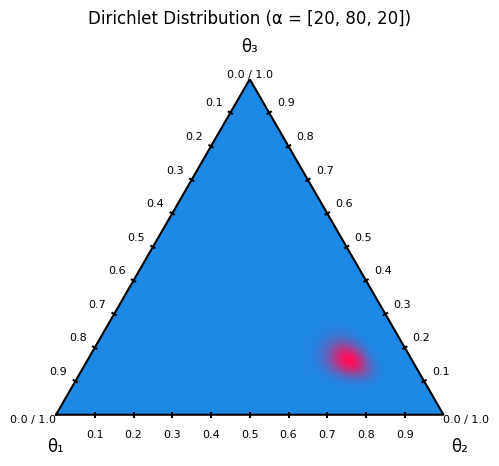

<Axes: title={'center': 'Dirichlet Distribution (α = [20, 80, 20])'}>

In [7]:
bigAlphaValues = np.array([20, 80, 20])  # noqa: N816

create_dirichlet_plot(alpha=bigAlphaValues)

**Bigger alpha values** lead to a concentrated distribution.

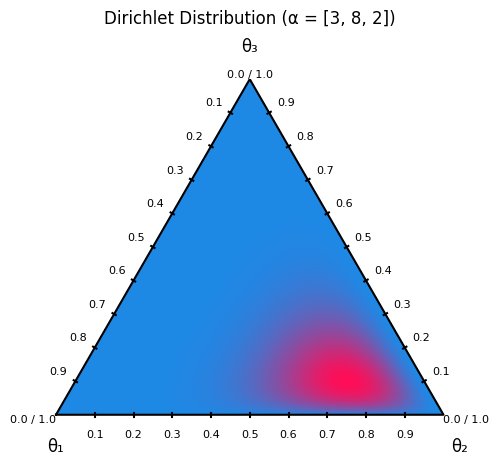

<Axes: title={'center': 'Dirichlet Distribution (α = [3, 8, 2])'}>

In [9]:
small_alpha_values = np.array([3, 8, 2])

create_dirichlet_plot(small_alpha_values)

**Smaller alpha values** lead to a more unconcetrated distribution.